# Modeling Predicting The Voter Participation Rate Per Election

This section predicts the voter participation rate per county.
Counties vote habitually, so the participation in the previous election is highly predicitve of the voter turnout in the subsequenct election. However there are not enough modern elections that would allow for a time series model. So this notebook Does a mini time series approach. The participation rate from the previous election is added as a feature to tease out the effects of the county's voter history. 

This notebook uses two models to predict the same target, and picks the most effective model. 
- [Linear Model](#section1)
- [Gradient Boost Regressor](#section2)

### Previous Notebook [Linear Modeling](Strike_a_Line_Pose.ipynb)
### Next Notebook [Natural Language Processing Modeling](NLP_Pose.ipynb)

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor

In [2]:
# set the number of columns show, so that all feature are visible when .head() is called
pd.set_option("display.max_columns", 999)

In [3]:
# read in relevant files, EDA output

df_2004 = pd.read_csv('./csv_files/df_2004')
df_2008 = pd.read_csv('./csv_files/df_2008')
df_2012 = pd.read_csv('./csv_files/df_2012')
df_2016 = pd.read_csv('./csv_files/df_2016')

In [4]:
df_2008['previous_year_total'] = df_2004['total_vote_ratio']
df_2008['previous_year_dem'] = df_2004['dem_vote_ratio']
df_2008['previous_year_rep'] = df_2004['rep_vote_ratio']
df_2008['previous_year_dif'] = df_2004['vote_diff']

df_2012['previous_year_total'] = df_2008['total_vote_ratio']
df_2012['previous_year_dem'] = df_2008['dem_vote_ratio']
df_2012['previous_year_rep'] = df_2008['rep_vote_ratio']
df_2012['previous_year_dif'] = df_2008['vote_diff']

df_2016['previous_year_total'] = df_2012['total_vote_ratio']
df_2016['previous_year_dem'] = df_2012['dem_vote_ratio']
df_2016['previous_year_rep'] = df_2012['rep_vote_ratio']
df_2016['previous_year_dif'] = df_2012['vote_diff']

<a id='section1'></a>
# Linear Model

In [5]:
# drop two education cells to correct for multicollinearity

df_2008.drop(['per_bachelors_or_higher_2000', 'per_bachelors_change'], axis=1, inplace=True)
df_2012.drop(['per_bachelors_or_higher_2011', 'per_bachelors_change'], axis=1, inplace=True)
df_2016.drop(['per_bachelors_or_higher_2011', 'per_bachelors_change'], axis=1, inplace=True)

In [6]:
df_2008.head()

,oct_rate,nov_rate,density,per_pov,med_income,total_vote_ratio,dem_vote_ratio,rep_vote_ratio,vote_diff,continuum_2003,influence_2003,per_less_high_2000,per_high_diploma_2000,per_some_college_2000,per_less_high_change,per_high_dimploma_change,per_some_college_change,previous_year_total,previous_year_dem,previous_year_rep,previous_year_dif
0,8.8,8.9,0.019768,17.6,36041,0.420639,0.178451,0.242188,-0.063738,6,6,29.9,35.9,21.4,-11.2,2.5,6.7,0.374462,0.167296,0.207166,-0.039870
1,4.5,4.5,0.010722,19.7,37862,0.429616,0.114996,0.314620,-0.199624,4,5,35.3,38.0,17.2,-10.1,4.5,4.6,0.422471,0.150904,0.271567,-0.120663
2,4.7,5.2,0.013401,20.6,37564,0.454519,0.223933,0.230586,-0.006653,7,9,32.1,34.1,20.3,-8.4,0.6,3.5,0.364665,0.151942,0.212724,-0.060782
3,5.7,6.6,0.002757,9.0,57159,0.457119,0.214373,0.242746,-0.028373,2,2,9.2,23.1,36.5,-3.6,-2.9,0.2,0.454130,0.173859,0.280271,-0.106412
4,3.3,3.6,0.073487,10.0,44824,0.513618,0.247838,0.265780,-0.017942,8,7,12.2,48.4,28.2,-10.3,3.0,6.0,0.526998,0.228582,0.298416,-0.069834


In [7]:
def linear_model(df, target):
    '''Function takes in a dataframe and the target to predict, does a train test split and 
    outputs the score on the train and test data. Also print out predicted versus actual graphs, a scatterplot
    of the residuals and a bar chart of the coefficients to show which features are important.'''
    
    # if else statement to take the correct columns out of the data frame based on what the target variable is
    if target == 'total_vote_ratio':
        X = df.drop(['total_vote_ratio', 'dem_vote_ratio', 'rep_vote_ratio', 'vote_diff', 
                     'previous_year_dem', 'previous_year_rep', 'previous_year_dif'], axis=1)
    elif target == 'dem_vote_ratio':
        X = df.drop(['total_vote_ratio', 'dem_vote_ratio', 'rep_vote_ratio', 'vote_diff',
                     'previous_year_total', 'previous_year_rep', 'previous_year_dif'], axis=1)       
    elif target == 'rep_vote_ratio':
        X = df.drop(['total_vote_ratio', 'dem_vote_ratio', 'rep_vote_ratio', 'vote_diff',
                     'previous_year_total', 'previous_year_dem', 'previous_year_dif'], axis=1)
    elif target == 'vote_diff':
        X = df.drop(['total_vote_ratio', 'dem_vote_ratio', 'rep_vote_ratio', 'vote_diff',
                     'previous_year_total', 'previous_year_dem', 'previous_year_rep'], axis=1)
        
    y = df[target]
    
    # Train test split with random state for reproducible results
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

    # Standardize Data becasue this function uses a parametric model
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train)
    X_test = ss.transform(X_test)
    
    lm = LinearRegression()
    model = lm.fit(X_train, y_train)

    # print the score and cross validated score of the model
    print('Cross Validated R^2 on train', cross_val_score(lm, X_train, y_train).mean())
    print('Cross Validated R^2 on test', cross_val_score(lm, X_test, y_test, cv=5).mean())
    
    R2 = lm.score(X_train, y_train).mean()
    n = X_train.shape[0]
    k = X_train.shape[1]

    
    adj_R2 = 1-float((1-R2)*(n-1))/(n-k-1)
    
    print('Adujusted R^2', adj_R2)
    
    predictions = lm.predict(X_test)
    
    print('Mean Squared Error', np.sqrt(mean_squared_error(y_test, predictions)))
    
    
    # The colors of the graphs is dependent on the target variable to easily see what the graphs show
    
    if target == 'total_vote_ratio' or target == 'total_diff':
        color = 'rebeccapurple'
    elif target == 'dem_vote_ratio' or target == 'dem_diff':
        color = 'cornflowerblue'
    elif target == 'rep_vote_ratio' or target == 'rep_diff':
        color = 'firebrick'
    else:
        color = 'forestgreen'

    # scatter plot of the predictions on the train data set, across from the actualy y_train    
    plt.scatter(y_train, lm.predict(X_train), alpha=.1, color=color)
    plt.title('Train Predictions v. Actual', fontsize=15)
    plt.show()
    
        
    plt.scatter(y_test, predictions, alpha=.1, color=color)
    plt.title('Test Predictions v. Actual', fontsize=15)
    plt.show()
    
    residuals = y_test - lm.predict(X_test)
    
    plt.scatter(y_test, residuals, alpha=.1, color=color)
    plt.title('Residuals', fontsize=15)
    plt.show()
    
    plt.hist(residuals, bins=25, color=color)
    plt.title('Histogram of Residuals', fontsize=15)
    plt.show()

    
    feature_importance = pd.DataFrame()
    feature_importance['feature_name'] = X.columns
    feature_importance['coefficients'] = lm.coef_

    
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 10)
    
    feature_importance = feature_importance.sort_values('coefficients')
    feat = feature_importance['feature_name'][:-1]
    y_pos = np.arange(len(feat))
    coeff = feature_importance['coefficients'][:-1]
    
    ax.barh(y_pos, coeff, align='center', color=color)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(feat, fontsize=15)
    ax.invert_yaxis() 
    plt.title('Feature Importance', fontsize=20)
    plt.show()

# 2008

/Users/Penelope/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


Cross Validated R^2 on train 0.772643196742
Cross Validated R^2 on test 0.81783678493
Adujusted R^2 0.778283830753473
Mean Squared Error 0.0328903335977


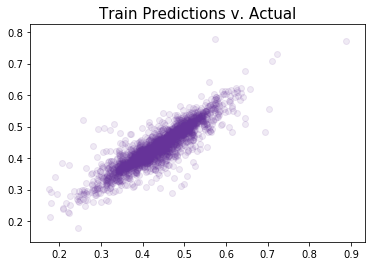

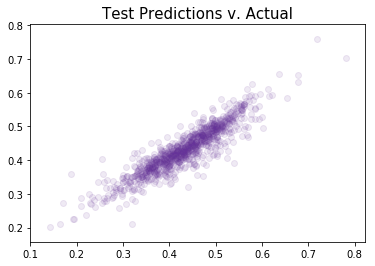

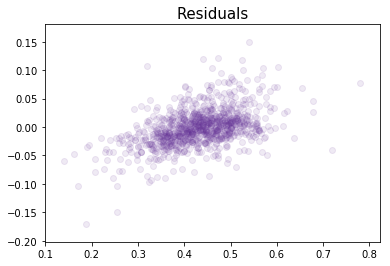

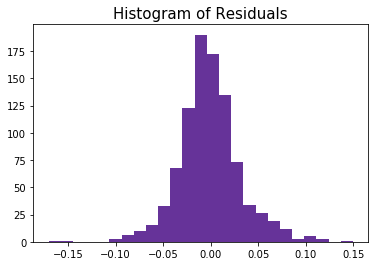

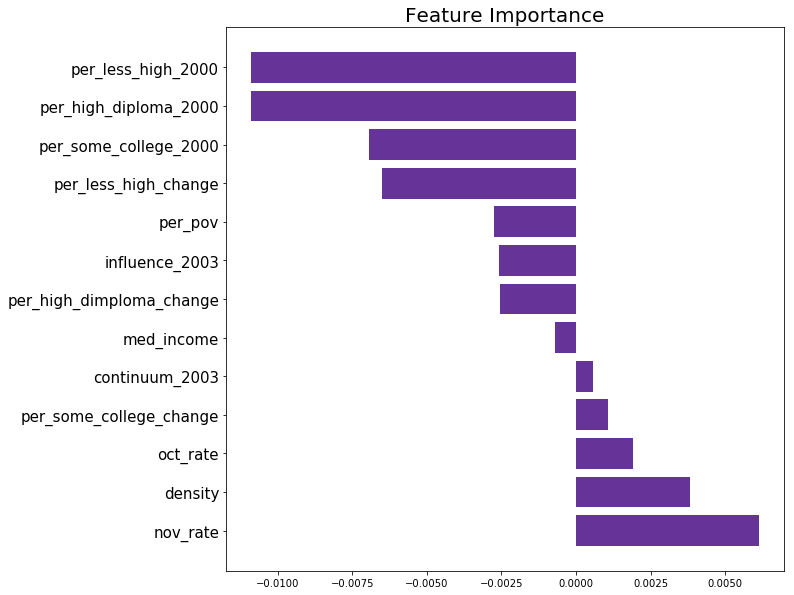

In [8]:
linear_model(df_2008, 'total_vote_ratio')

Cross Validated R^2 on train 0.852594725467
Cross Validated R^2 on test 0.862095320683
Adujusted R^2 0.8542744100003384
Mean Squared Error 0.0271657942127


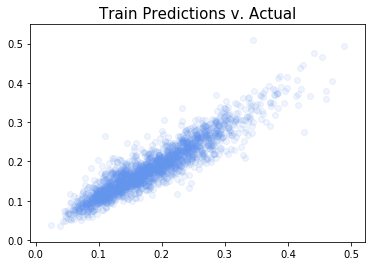

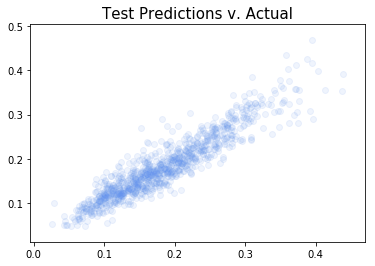

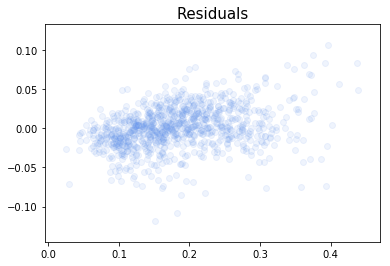

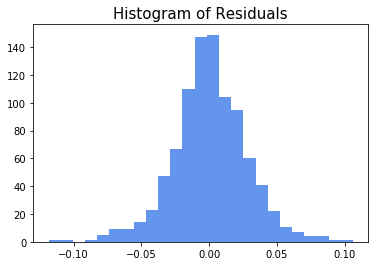

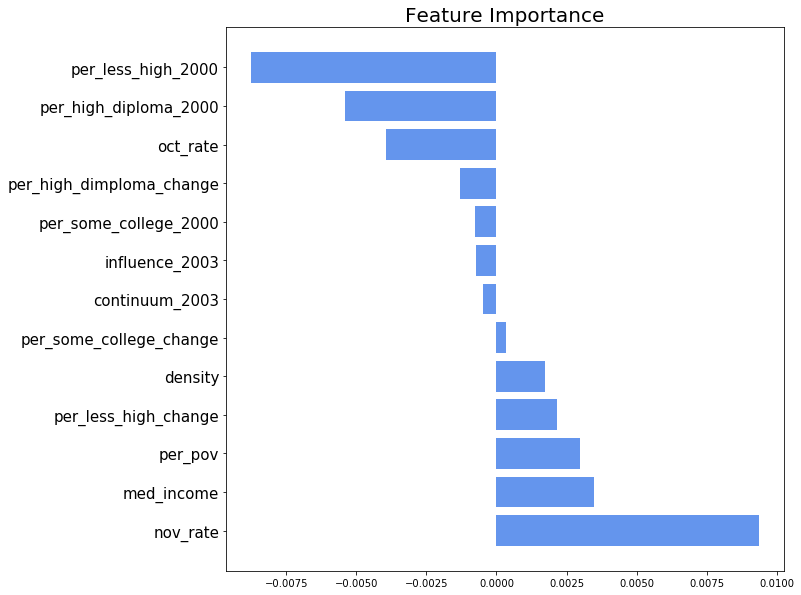

In [9]:
linear_model(df_2008, 'dem_vote_ratio')

Cross Validated R^2 on train 0.872724691296
Cross Validated R^2 on test 0.879307098028
Adujusted R^2 0.8754474138064402
Mean Squared Error 0.023877006024


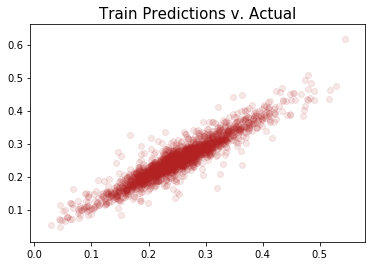

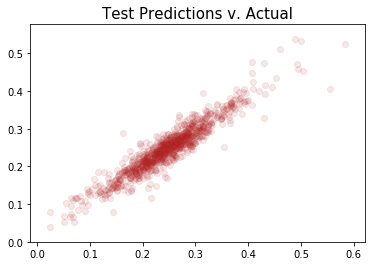

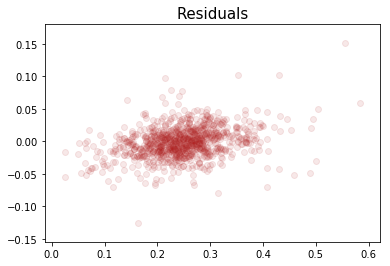

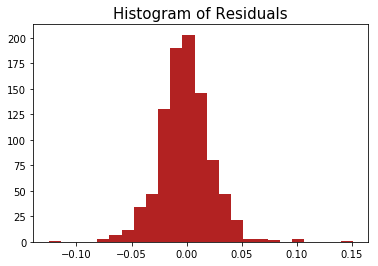

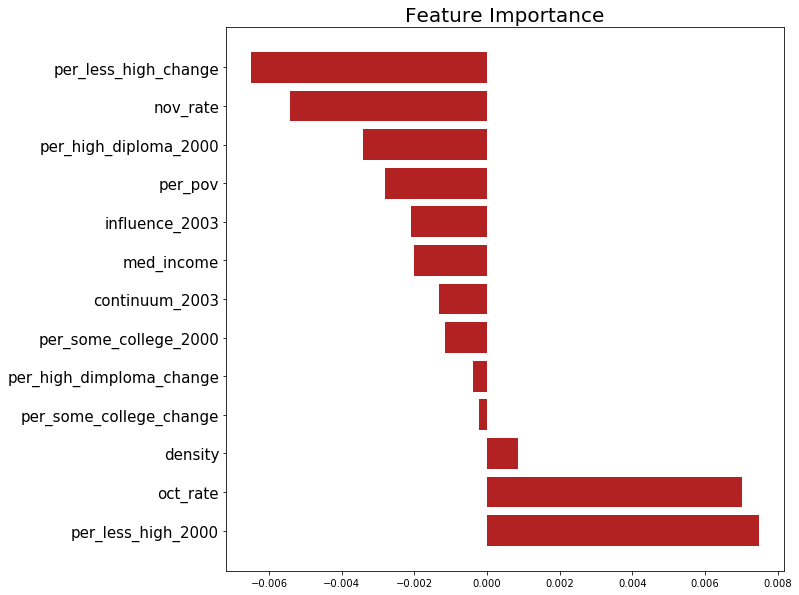

In [10]:
linear_model(df_2008, 'rep_vote_ratio')

Cross Validated R^2 on train 0.902038505723
Cross Validated R^2 on test 0.897152270709
Adujusted R^2 0.9037004812670878
Mean Squared Error 0.0382590171855


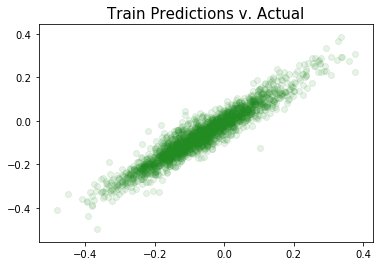

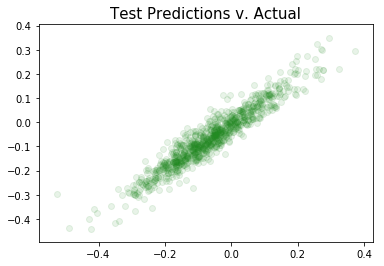

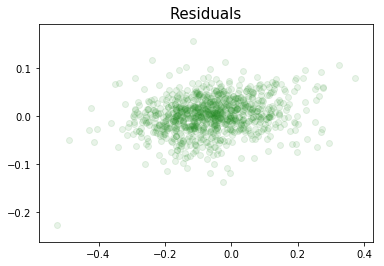

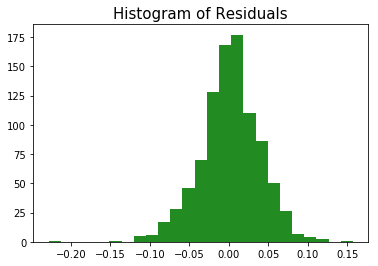

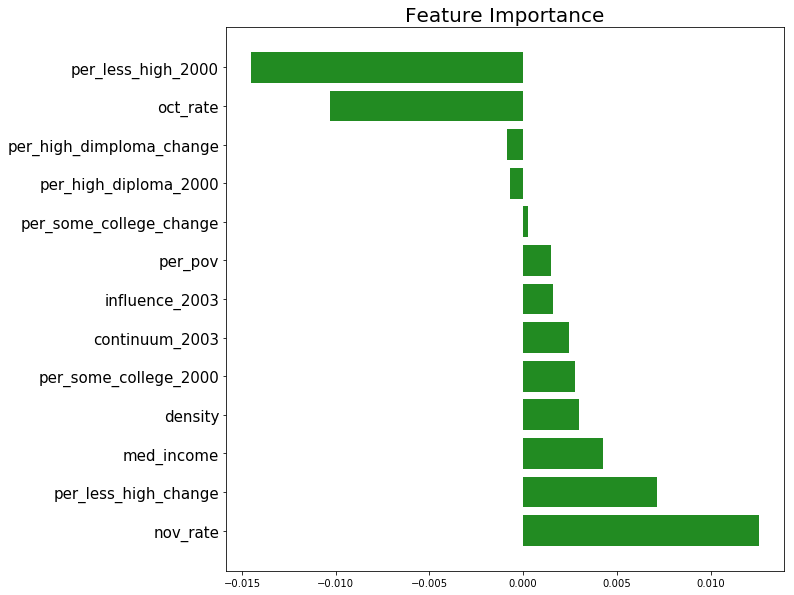

In [11]:
linear_model(df_2008, 'vote_diff')

# 2012

Cross Validated R^2 on train 0.869695034184
Cross Validated R^2 on test 0.902340165818
Adujusted R^2 0.8720722035216913
Mean Squared Error 0.0260999869494


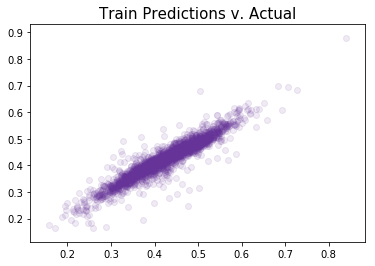

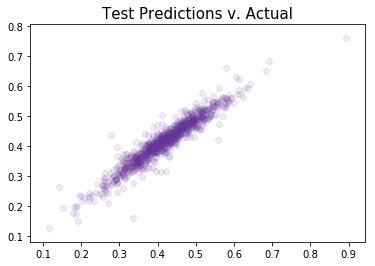

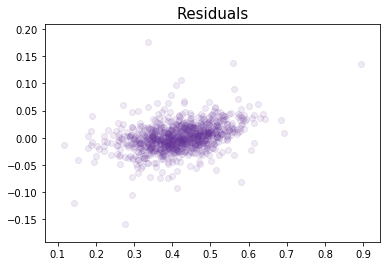

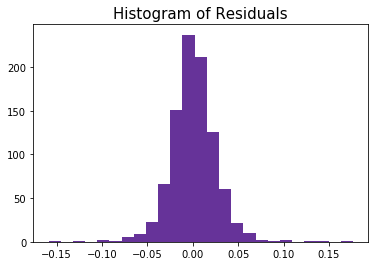

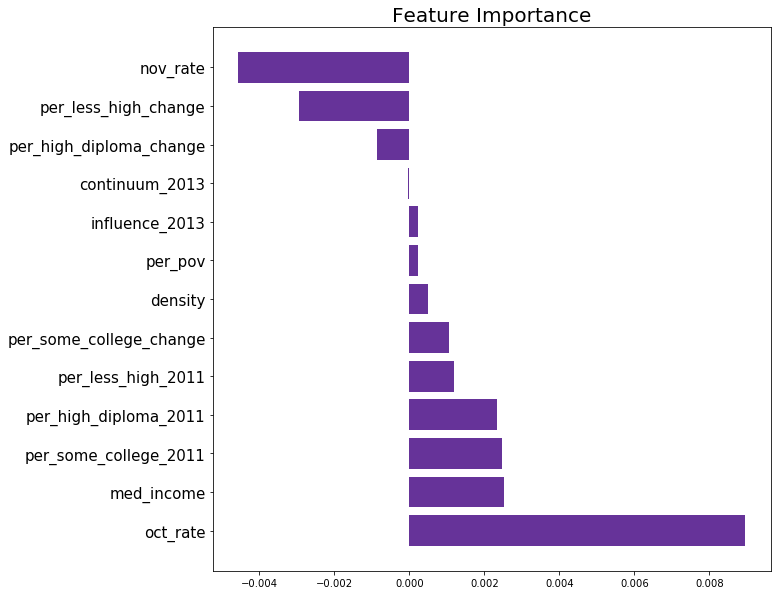

In [12]:
linear_model(df_2012, 'total_vote_ratio')

Cross Validated R^2 on train 0.942202304301
Cross Validated R^2 on test 0.944425206806
Adujusted R^2 0.9431642331845207
Mean Squared Error 0.0177507932809


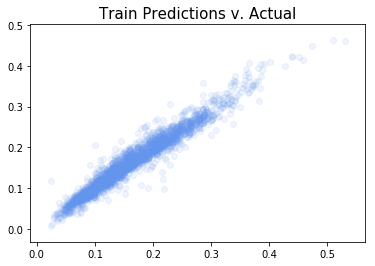

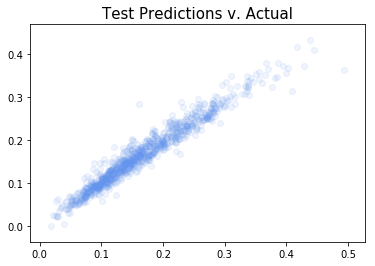

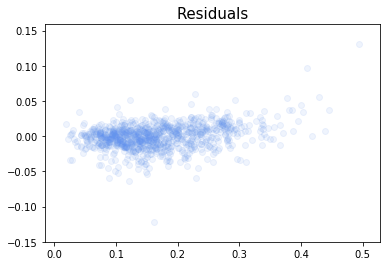

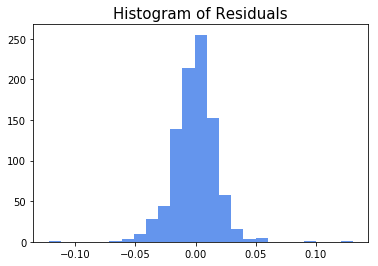

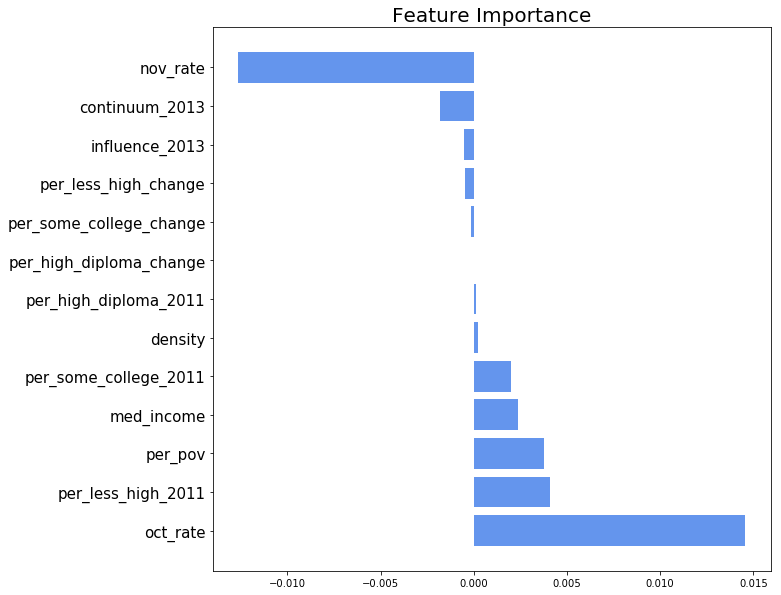

In [13]:
linear_model(df_2012, 'dem_vote_ratio')

Cross Validated R^2 on train 0.924136281915
Cross Validated R^2 on test 0.936115868964
Adujusted R^2 0.9257166462203625
Mean Squared Error 0.0193783217642


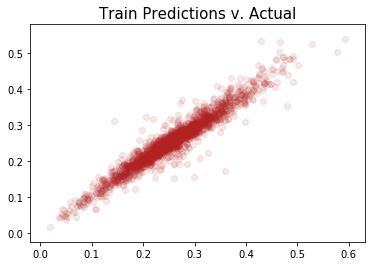

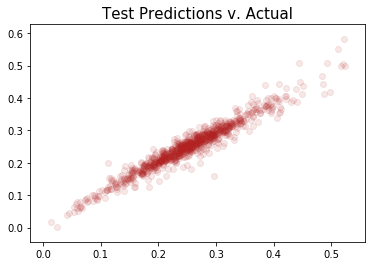

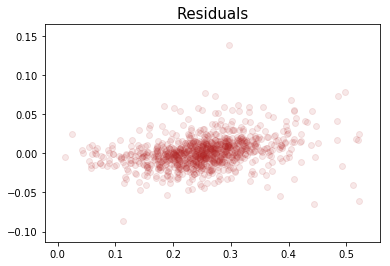

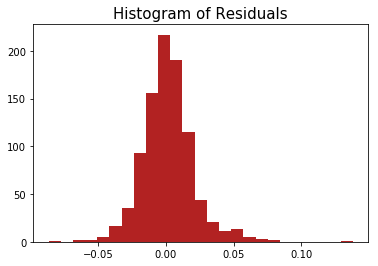

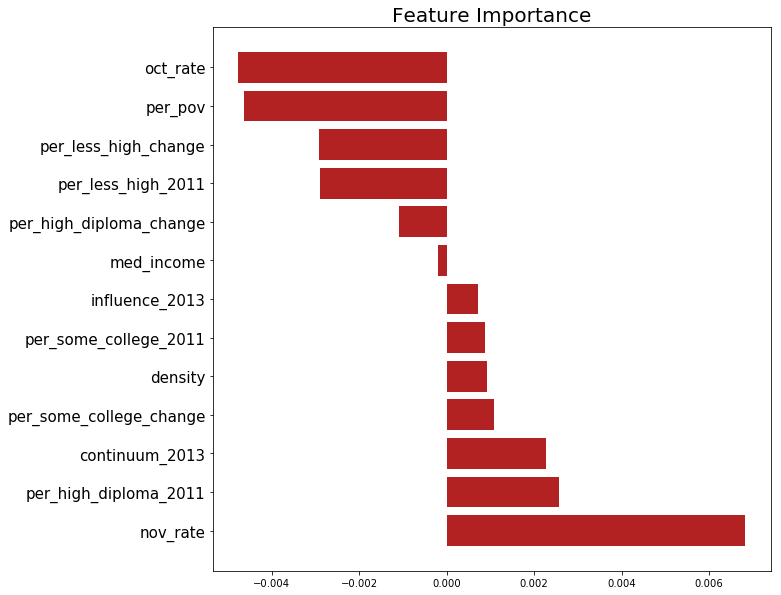

In [14]:
linear_model(df_2012, 'rep_vote_ratio')

Cross Validated R^2 on train 0.957497467655
Cross Validated R^2 on test 0.955965497078
Adujusted R^2 0.958325914784433
Mean Squared Error 0.0265507822324


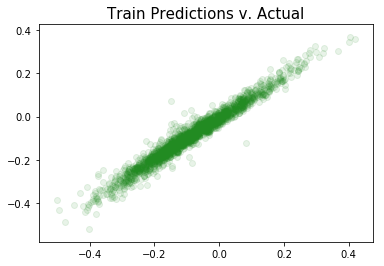

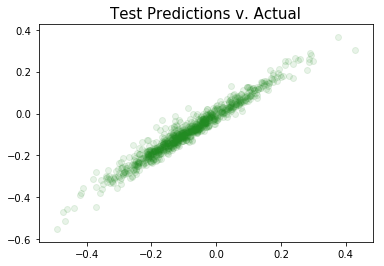

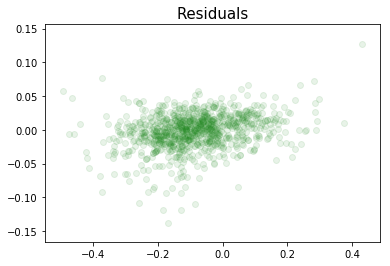

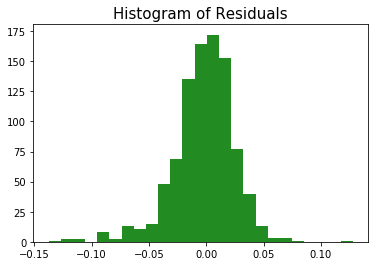

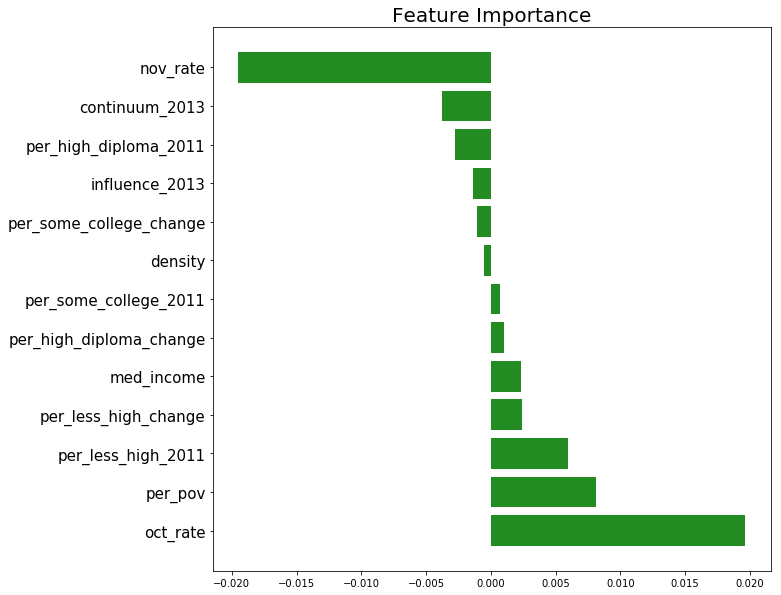

In [15]:
linear_model(df_2012, 'vote_diff')

# 2016

Cross Validated R^2 on train 0.889709536957
Cross Validated R^2 on test 0.880729489448
Adujusted R^2 0.891122649861869
Mean Squared Error 0.0273372425518


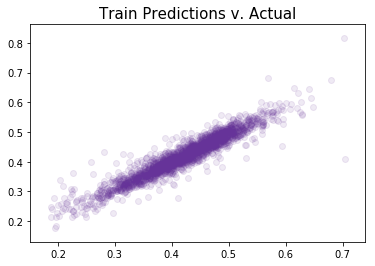

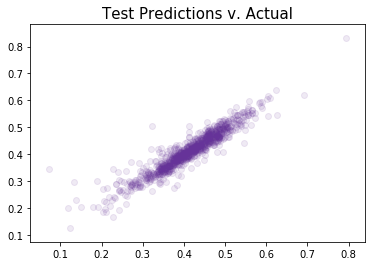

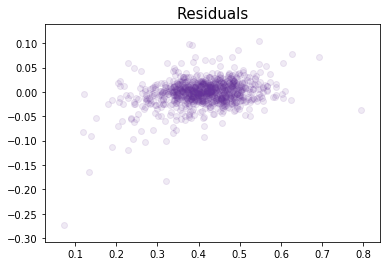

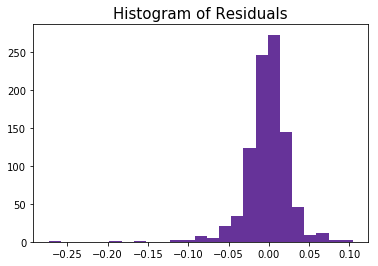

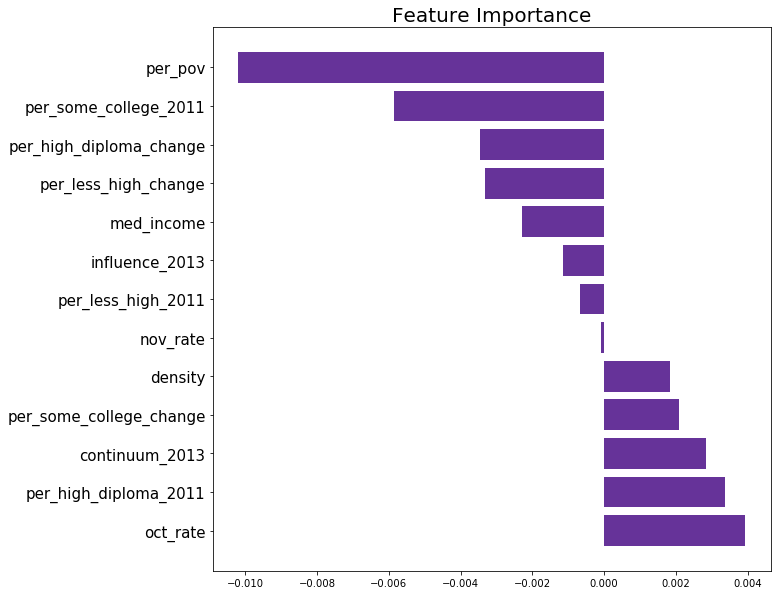

In [16]:
linear_model(df_2016, 'total_vote_ratio')

Cross Validated R^2 on train 0.952568175168
Cross Validated R^2 on test 0.949195374349
Adujusted R^2 0.9540385721024821
Mean Squared Error 0.0157615718731


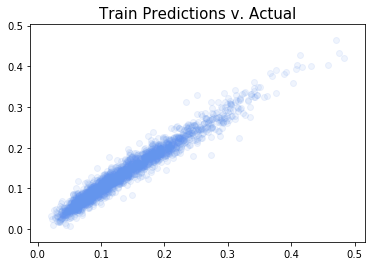

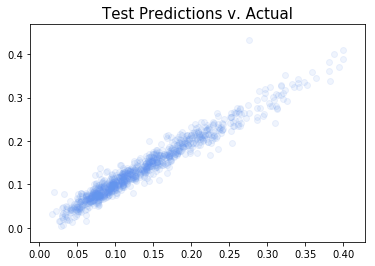

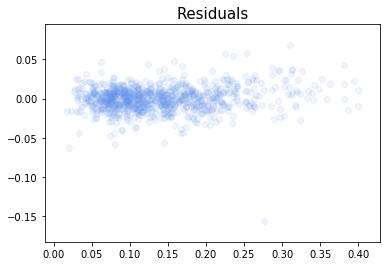

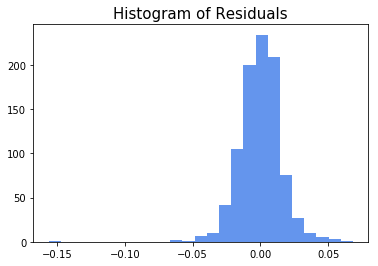

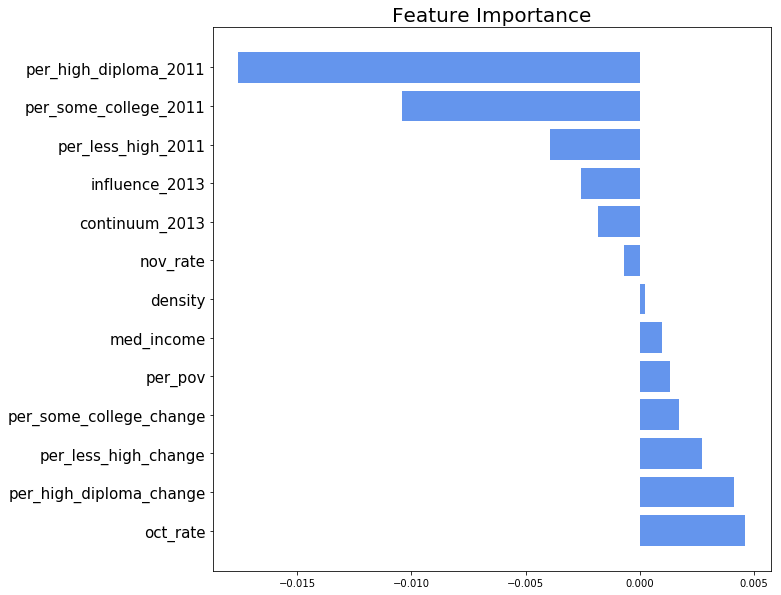

In [17]:
linear_model(df_2016, 'dem_vote_ratio')

Cross Validated R^2 on train 0.931344792344
Cross Validated R^2 on test 0.923898880293
Adujusted R^2 0.9324222080030499
Mean Squared Error 0.0232628682422


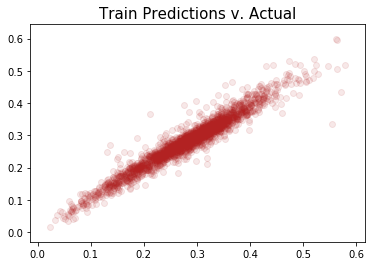

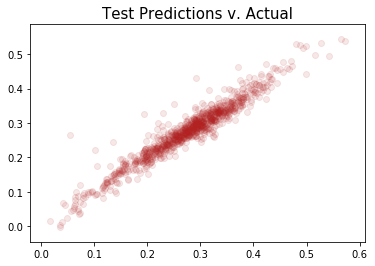

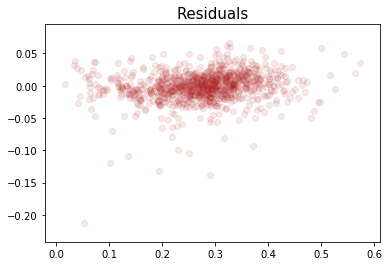

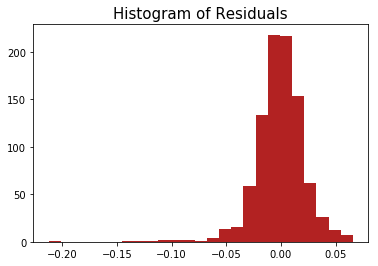

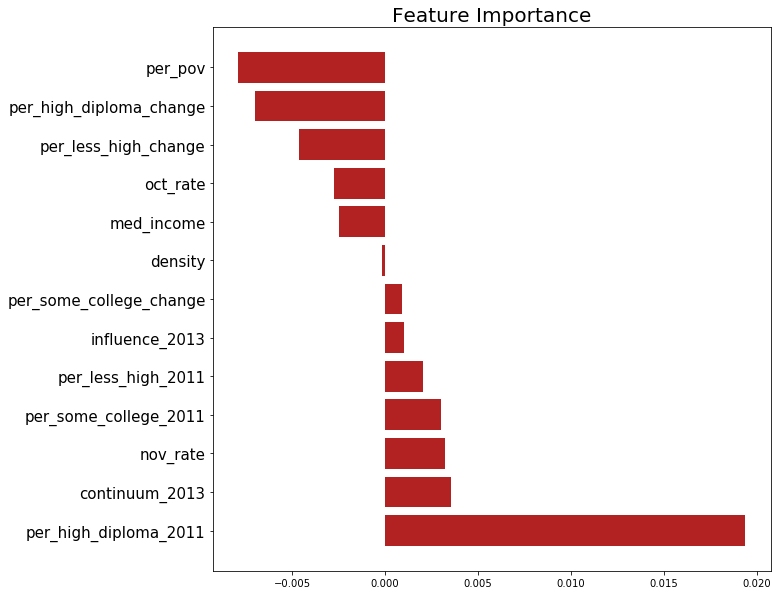

In [18]:
linear_model(df_2016, 'rep_vote_ratio')

Cross Validated R^2 on train 0.952603216415
Cross Validated R^2 on test 0.949799463951
Adujusted R^2 0.954005855240053
Mean Squared Error 0.0297517818902


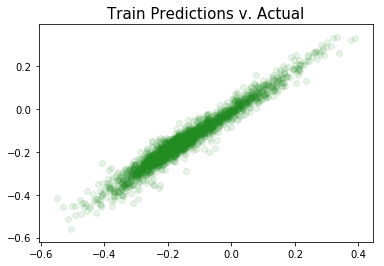

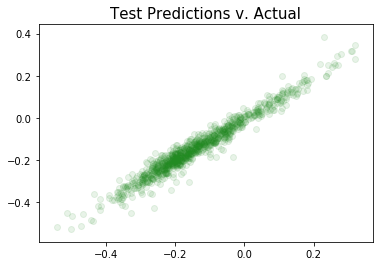

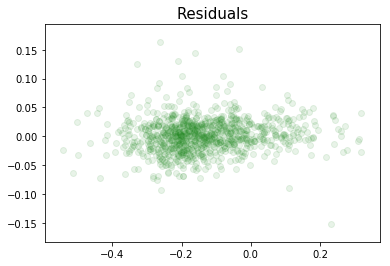

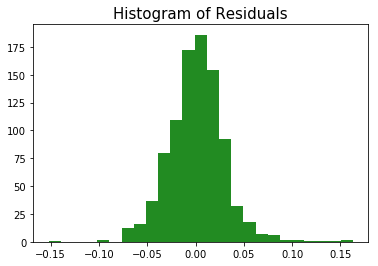

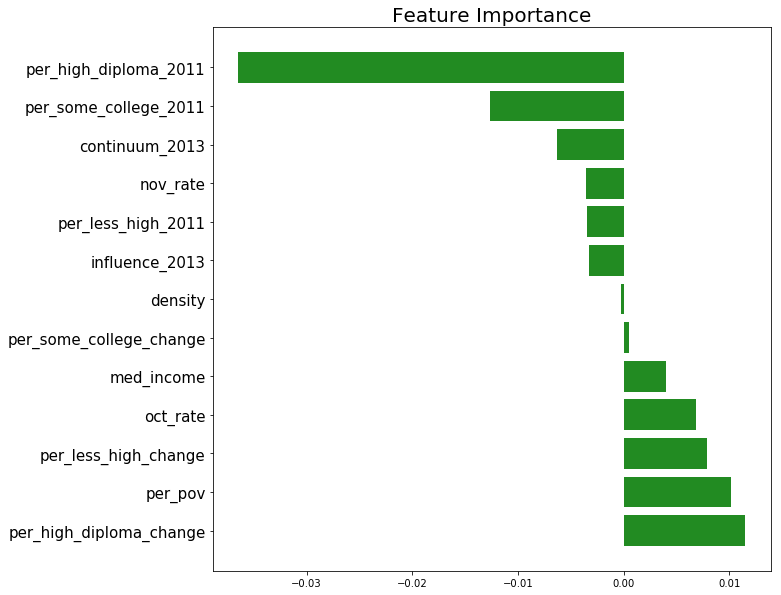

In [19]:
linear_model(df_2016, 'vote_diff')

<a id='section2'></a>
# Gradient Boost Regressor

In [20]:
def grad_model(df, target):
    
    if target == 'total_vote_ratio':
        X = df.drop(['total_vote_ratio', 'dem_vote_ratio', 'rep_vote_ratio', 'vote_diff', 
                     'previous_year_dem', 'previous_year_rep', 'previous_year_dif'], axis=1)
    elif target == 'dem_vote_ratio':
        X = df.drop(['total_vote_ratio', 'dem_vote_ratio', 'rep_vote_ratio', 'vote_diff',
                     'previous_year_total', 'previous_year_rep', 'previous_year_dif'], axis=1)       
    elif target == 'rep_vote_ratio':
        X = df.drop(['total_vote_ratio', 'dem_vote_ratio', 'rep_vote_ratio', 'vote_diff',
                     'previous_year_total', 'previous_year_dem', 'previous_year_dif'], axis=1)
    elif target == 'vote_diff':
        X = df.drop(['total_vote_ratio', 'dem_vote_ratio', 'rep_vote_ratio', 'vote_diff',
                     'previous_year_total', 'previous_year_dem', 'previous_year_rep'], axis=1)
        
    y = df[target]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

    ss = StandardScaler()
    X_train = ss.fit_transform(X_train)
    X_test = ss.transform(X_test)
    
    grad = GradientBoostingRegressor()
    model = grad.fit(X_train, y_train)

    print('R^2 on train', cross_val_score(grad, X_train, y_train).mean())
    print('R^2 on test', cross_val_score(grad, X_test, y_test, cv=5).mean())
    
    R2 = grad.score(X_train, y_train).mean()
    n = X_train.shape[0]
    k = X_train.shape[1]

    
    adj_R2 = 1-float((1-R2)*(n-1))/(n-k-1)
    
    print('Adujusted R^2', adj_R2)
    
    predictions = grad.predict(X_test)
    
    print('Mean Squared Error', np.sqrt(mean_squared_error(y_test, predictions)))
    
    if target == 'total_vote_ratio':
        color = 'rebeccapurple'
    elif target == 'dem_vote_ratio':
        color = 'cornflowerblue'
    elif target == 'rep_vote_ratio':
        color = 'firebrick'
    else:
        color = 'forestgreen'

    plt.scatter(y_train, grad.predict(X_train), alpha=.1, color=color)
    plt.title('Train Predictions versus Actual', fontsize=15)
    plt.show()    
        
    plt.scatter(y_test, predictions, alpha=.1, color=color)
    plt.title('Test Predictions versus Actual', fontsize=15)
    plt.show()
    
    residuals = y_test - grad.predict(X_test)
    
    plt.scatter(y_test, residuals, alpha=.1, color=color)
    plt.title('Residuals');
    plt.show()
    
    plt.hist(residuals, bins=25, color=color)
    plt.title('Histogram of Residuals', fontsize=15)
    plt.show()
    
    feature_importance = pd.DataFrame()
    feature_importance['feature_name'] = X.columns
    feature_importance['coefficients'] = grad.feature_importances_

    
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 10)
    
    feature_importance = feature_importance.sort_values('coefficients')
    feat = feature_importance['feature_name'][:-1]
    y_pos = np.arange(len(feat))
    coeff = feature_importance['coefficients'][:-1]
    
    ax.barh(y_pos, coeff, align='center', color=color)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(feat, fontsize=15)
    ax.invert_yaxis() 
    plt.title('Feature Importance', fontsize=20)
    plt.show()

# 2008

R^2 on train 0.774029294942
R^2 on test 0.81643605013
Adujusted R^2 0.8604448044961435
Mean Squared Error 0.0323430219136


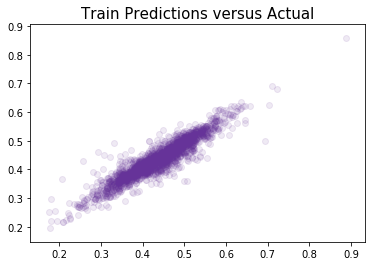

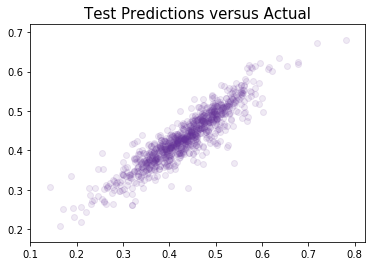

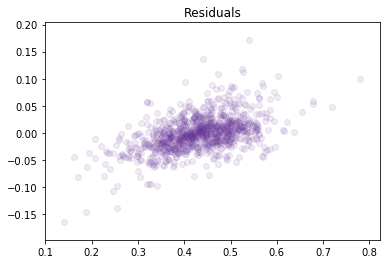

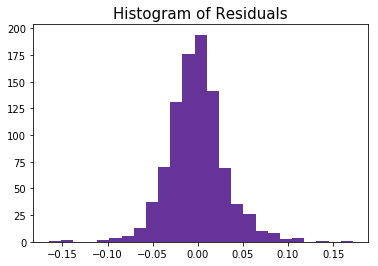

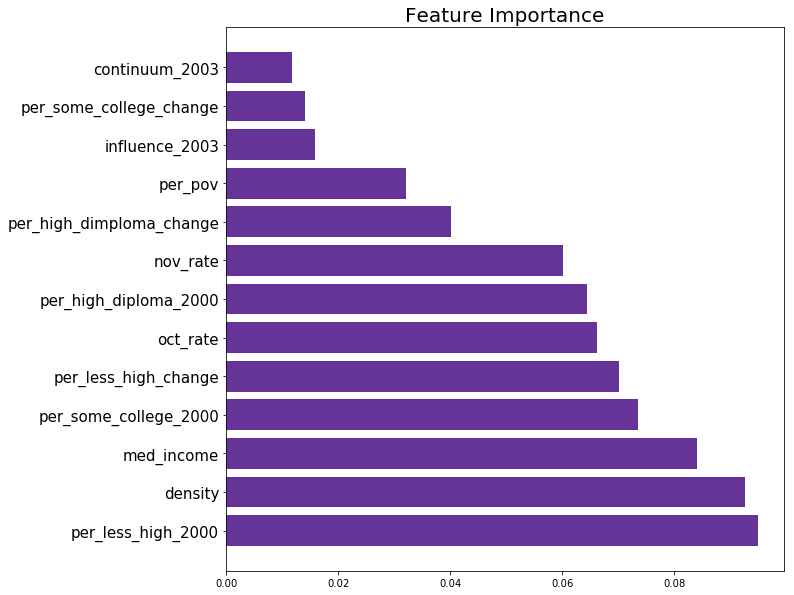

In [21]:
grad_model(df_2008, 'total_vote_ratio')

R^2 on train 0.864965509411
R^2 on test 0.860178948678
Adujusted R^2 0.9114805084931016
Mean Squared Error 0.0257280533915


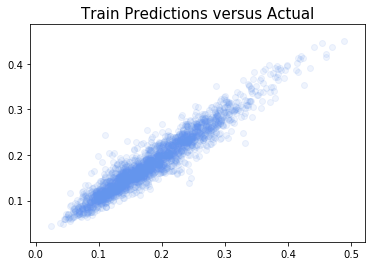

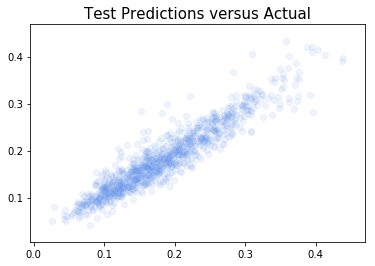

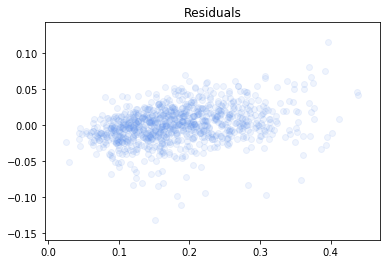

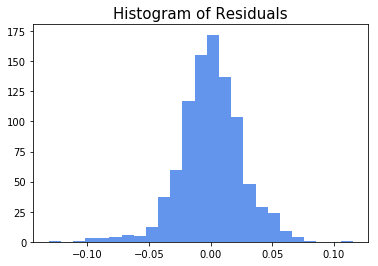

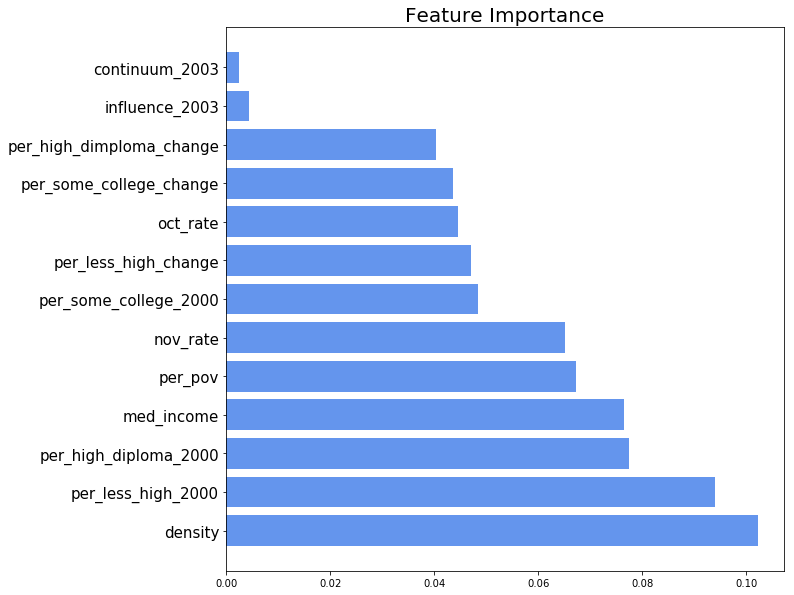

In [22]:
grad_model(df_2008, 'dem_vote_ratio')

R^2 on train 0.881058620522
R^2 on test 0.886630133929
Adujusted R^2 0.9224889724490256
Mean Squared Error 0.0225108717993


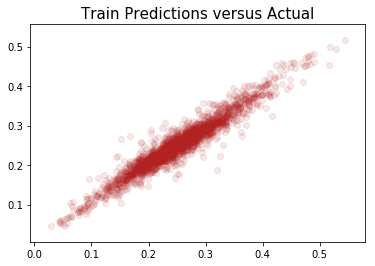

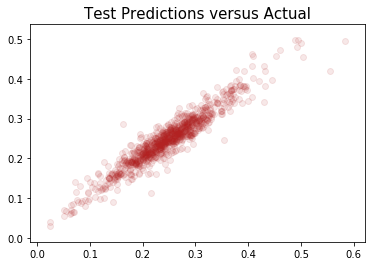

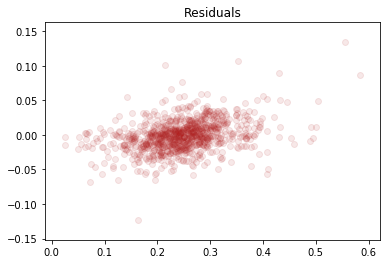

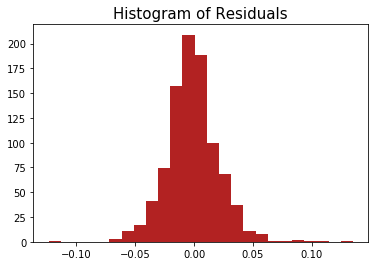

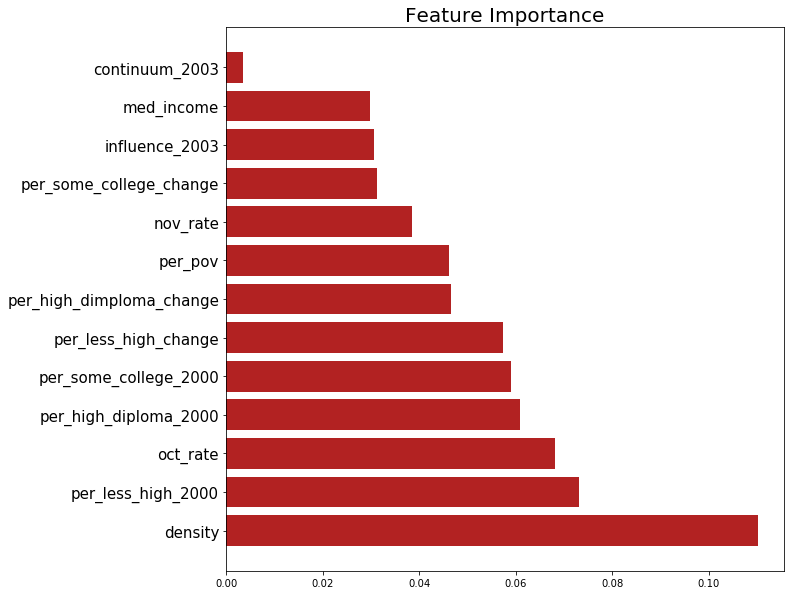

In [23]:
grad_model(df_2008, 'rep_vote_ratio')

R^2 on train 0.911838277659
R^2 on test 0.904729620387
Adujusted R^2 0.9433610934505233
Mean Squared Error 0.0355766606735


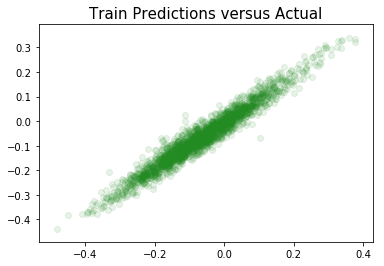

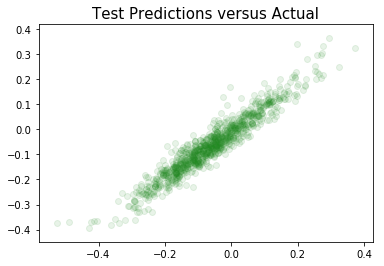

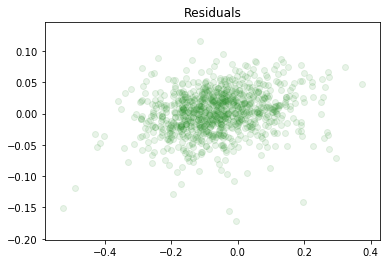

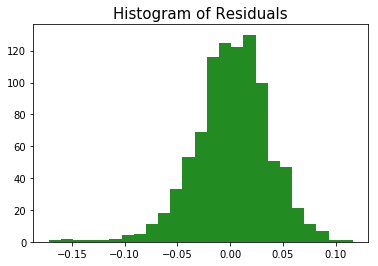

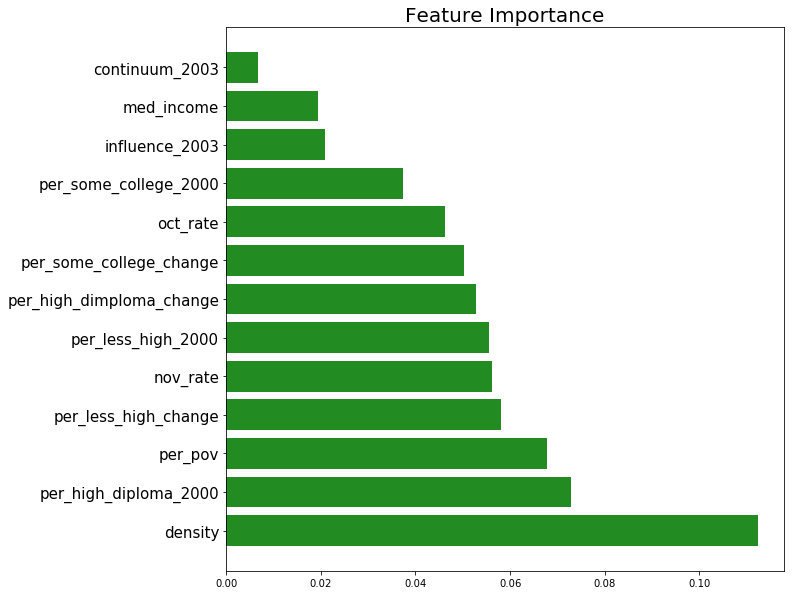

In [24]:
grad_model(df_2008, 'vote_diff')

# 2012

R^2 on train 0.87089368743
R^2 on test 0.890698139781
Adujusted R^2 0.923612323329961
Mean Squared Error 0.0264100494848


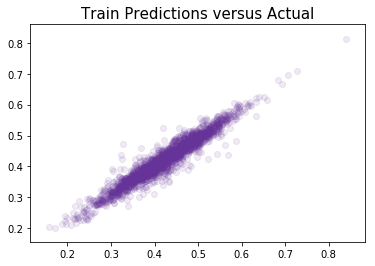

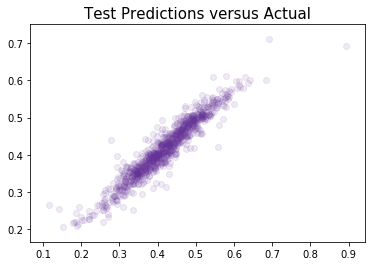

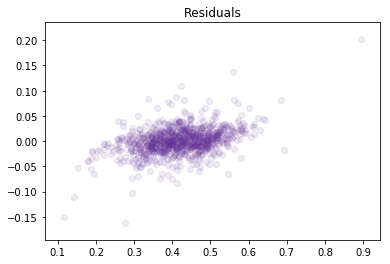

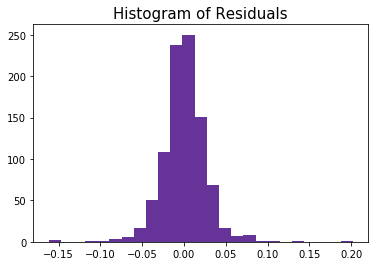

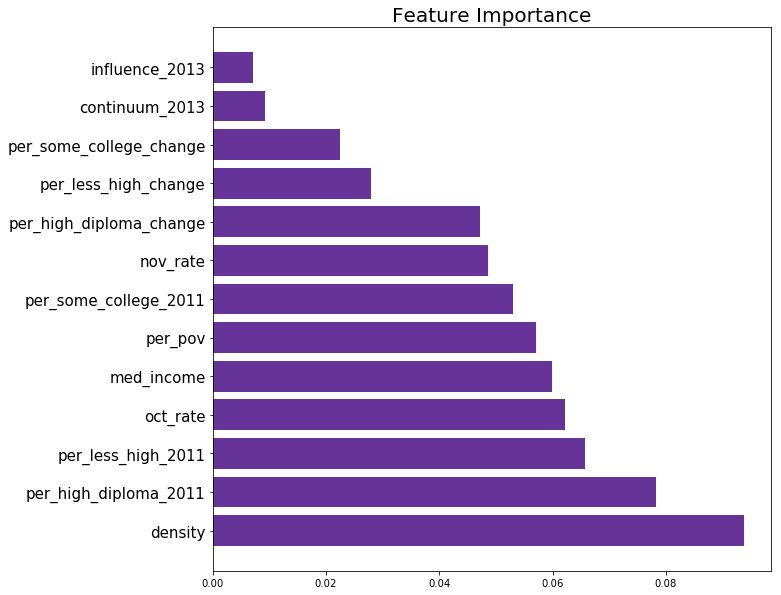

In [25]:
grad_model(df_2012, 'total_vote_ratio')

R^2 on train 0.943373925534
R^2 on test 0.94234103072
Adujusted R^2 0.9639424524624697
Mean Squared Error 0.0173389506755


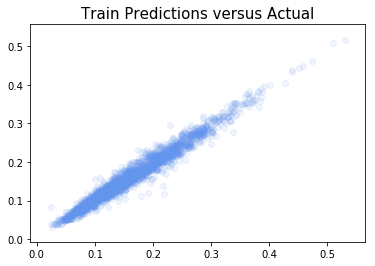

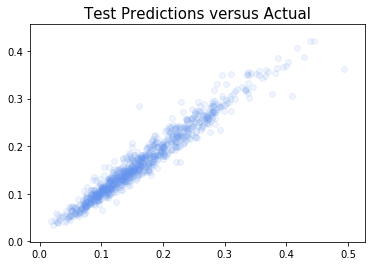

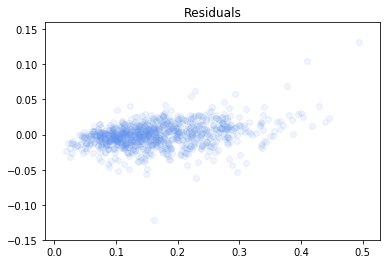

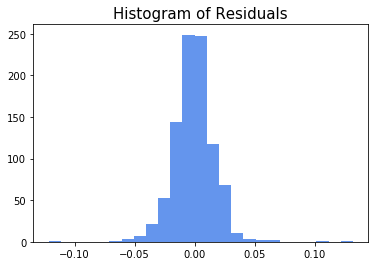

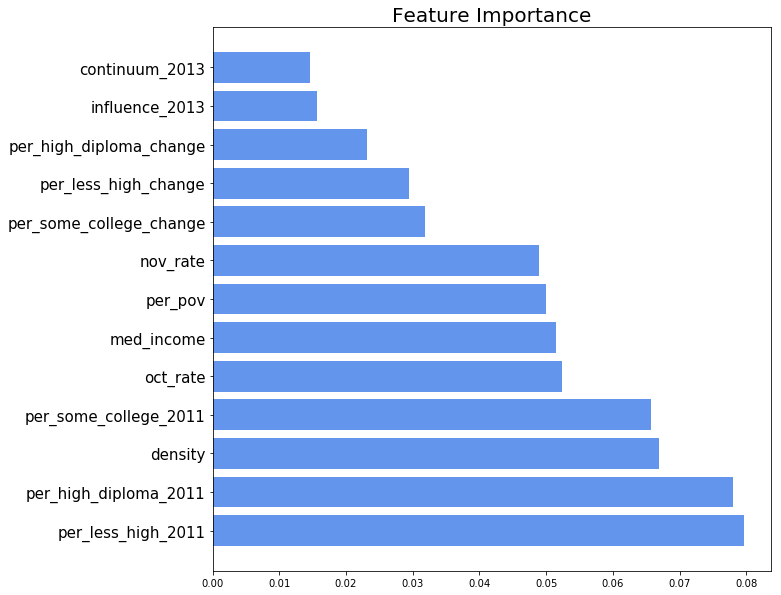

In [26]:
grad_model(df_2012, 'dem_vote_ratio')

R^2 on train 0.921833379954
R^2 on test 0.930178302553
Adujusted R^2 0.9525268230386112
Mean Squared Error 0.0194399084585


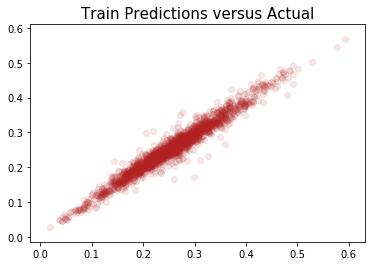

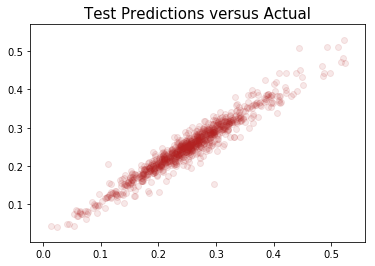

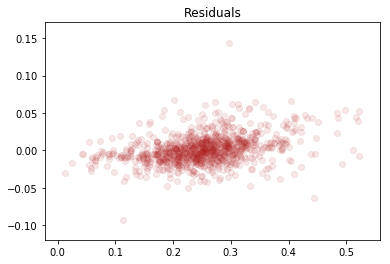

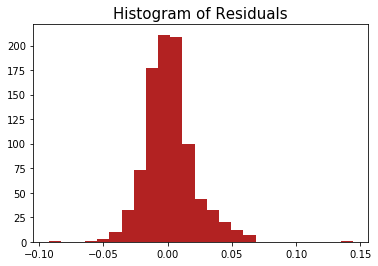

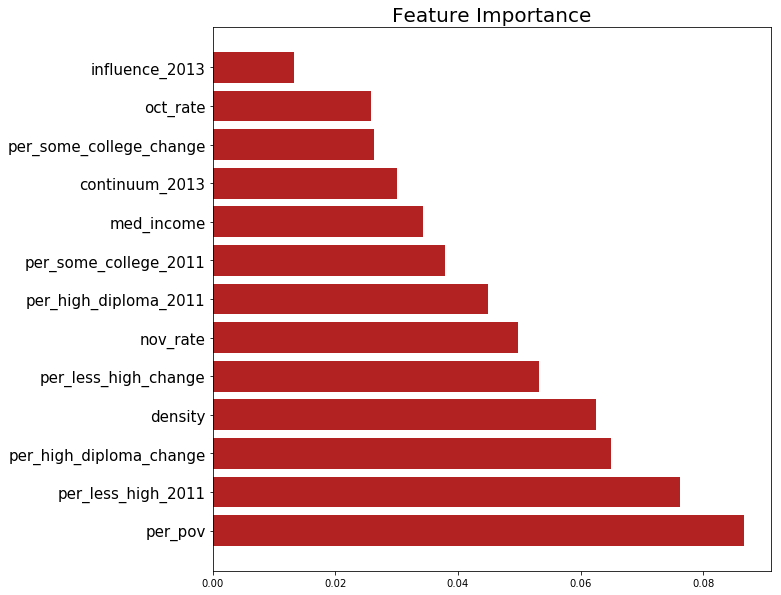

In [27]:
grad_model(df_2012, 'rep_vote_ratio')

R^2 on train 0.956154983819
R^2 on test 0.951913804258
Adujusted R^2 0.9741414811813232
Mean Squared Error 0.0261901179626


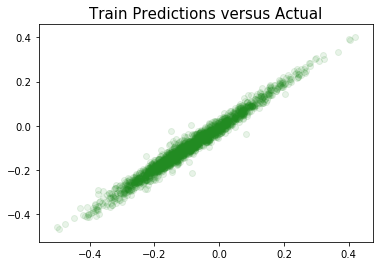

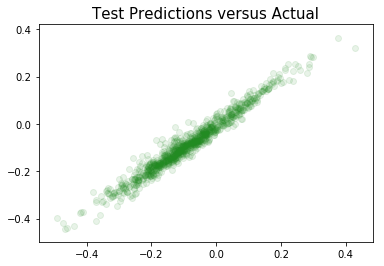

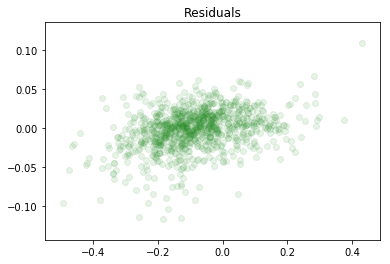

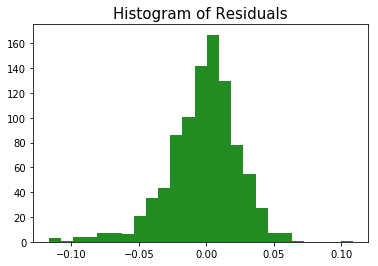

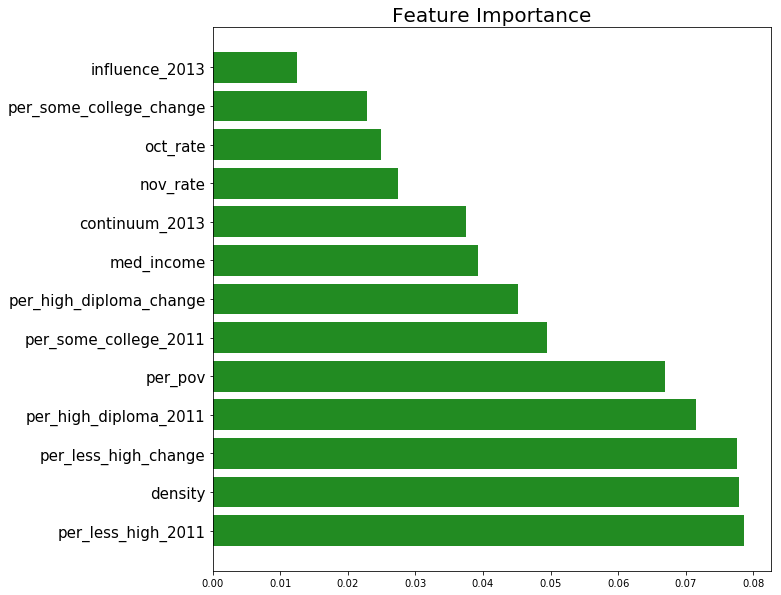

In [28]:
grad_model(df_2012, 'vote_diff')

# 2016

R^2 on train 0.88689446249
R^2 on test 0.868418887808
Adujusted R^2 0.9307109524632262
Mean Squared Error 0.0281151335621


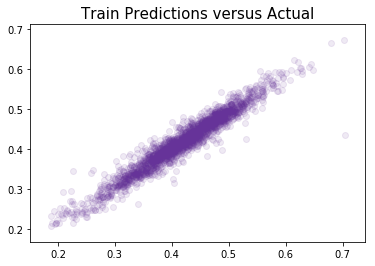

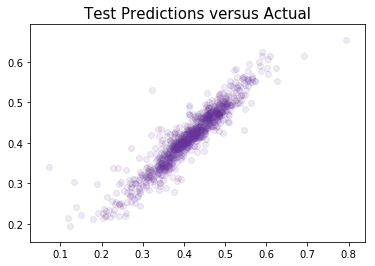

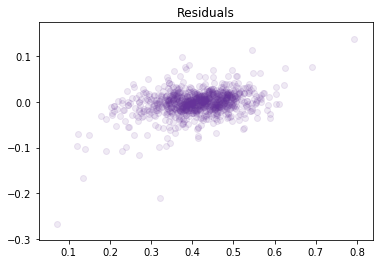

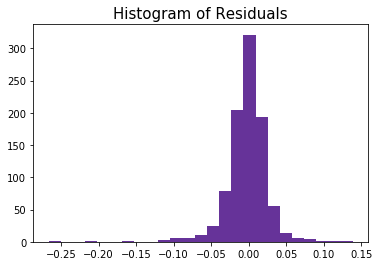

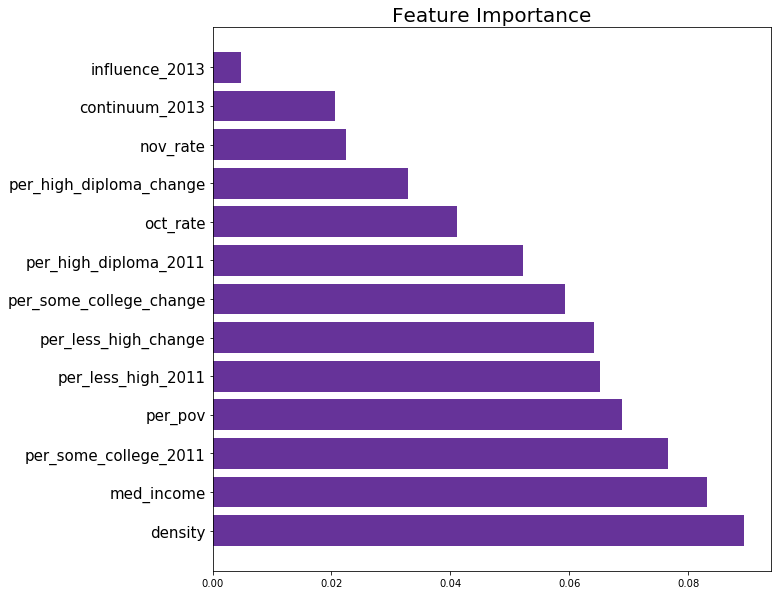

In [29]:
grad_model(df_2016, 'total_vote_ratio')

R^2 on train 0.953247345468
R^2 on test 0.950164394975
Adujusted R^2 0.9725566830196755
Mean Squared Error 0.0154534263297


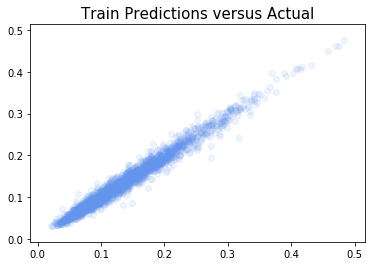

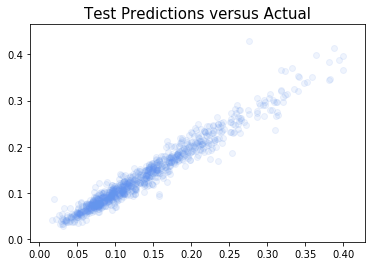

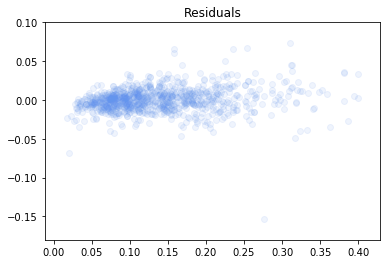

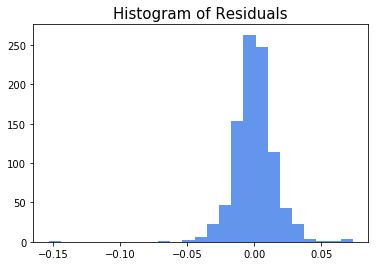

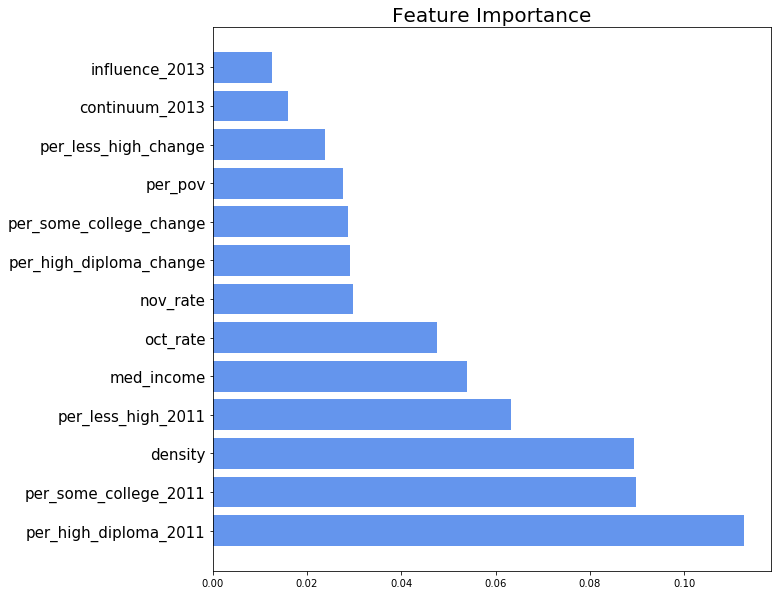

In [30]:
grad_model(df_2016, 'dem_vote_ratio')

R^2 on train 0.927898888193
R^2 on test 0.915236604759
Adujusted R^2 0.9566721470882463
Mean Squared Error 0.0239132235802


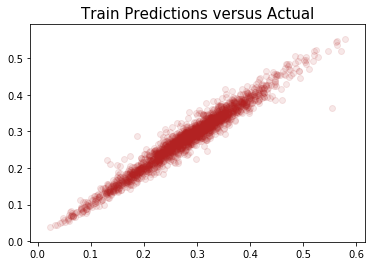

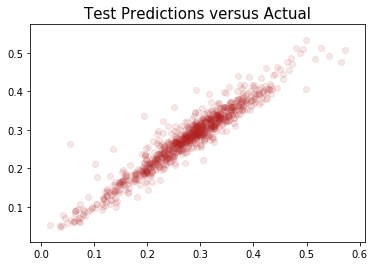

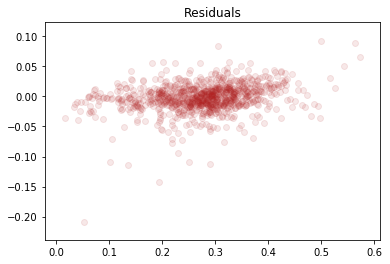

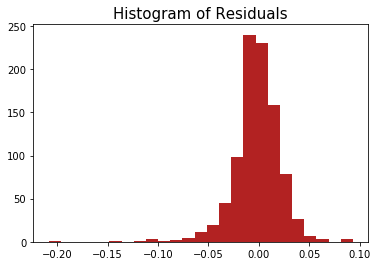

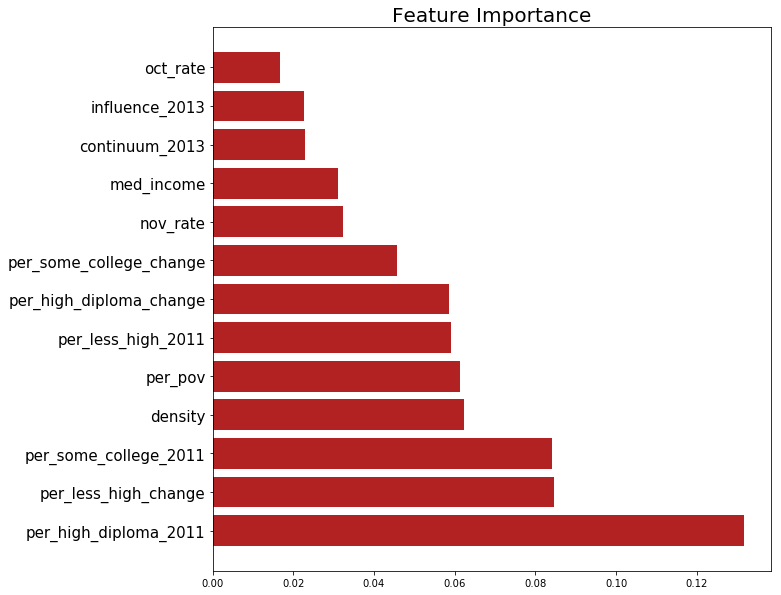

In [31]:
grad_model(df_2016, 'rep_vote_ratio')

R^2 on train 0.951797925326
R^2 on test 0.950983399912
Adujusted R^2 0.9716157648580505
Mean Squared Error 0.0293201144831


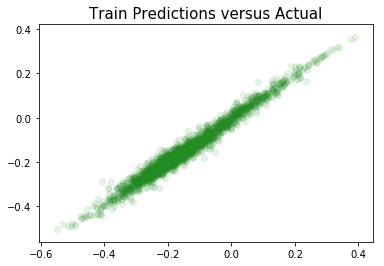

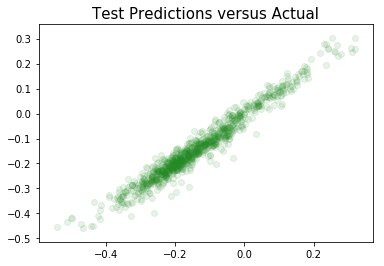

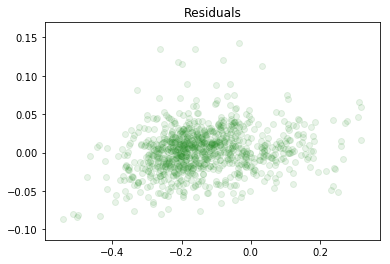

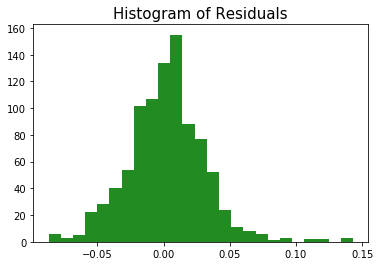

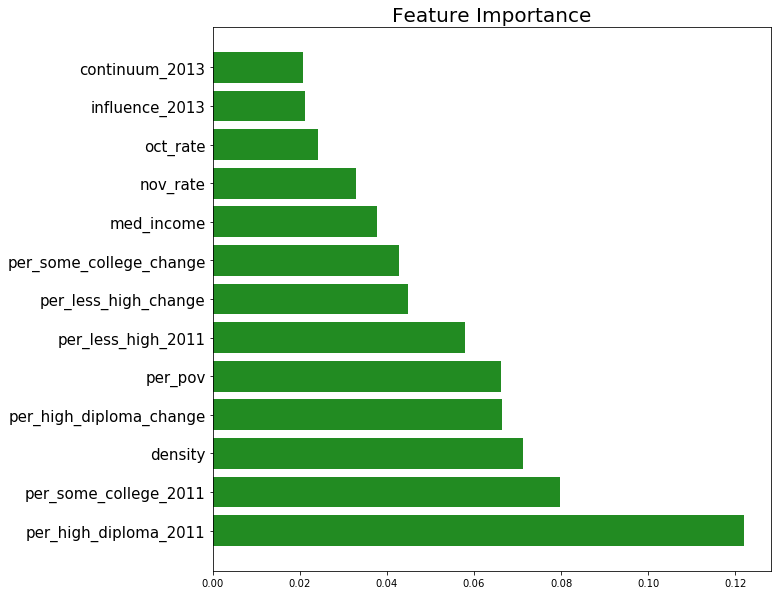

In [32]:
grad_model(df_2016, 'vote_diff')

### Next Notebook [Natural Language Processing Modeling](NLP_Pose.ipynb)